# Notebook 4B: Nonlinear SVM Classification 

#### Conceptualized, organized and prepared by: Christopher Monterola

Another reason why SVMs enjoy high popularity among machine learning
practitioners is that it can be easily *kernelized* to solve nonlinear classification
problems. Before we discuss the main concept behind a kernel SVM, let's first
create a sample dataset to see what such a nonlinear classification problem may
look like.

#### This notebook is based on the following references:

Python Machine Learning by Sebastian Raschka and Vahid Mirjalili, Second Edition, September 2017.    
Hands-On Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron, 2017

## General Idea:  Kernel methods for linearly inseparable data

### Using the kernel trick to find separating hyperplanes in high-dimensional space

To solve a nonlinear problem using an SVM, we would transform the training data
onto a higher-dimensional feature space via a mapping function $\phi$ and train a linear
SVM model to classify the data in this new feature space. Then, we can use the same
mapping function $\phi$ to transform new, unseen data to classify it using the linear
SVM model.

However, one problem with this mapping approach is that the construction of the new features is computationally very expensive, especially if we are dealing with high-dimensional data. This is where the so-called kernel trick comes into
play. Although we didn't go into much detail about how to solve the quadratic
programming task to train an SVM, in practice all we need is to replace the dot
product $\mathbf{x}^{(i)^T} \mathbf{x}^{(j)}$ by $\phi(\mathbf{x}^{(i)})^T\phi(\mathbf{x}^{(j)})$. In order to save the expensive step of
calculating this dot product between two points explicitly, we define a so-called
kernel function: $\kappa(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})=\phi(\mathbf{x}^{(i)})^T\phi(\mathbf{x}^{(j)})$ 

Obviously, we would not be able to separate samples from the positive and negative
class very well using a linear hyperplane as a decision boundary via the linear
logistic regression or linear SVM model that we discussed in earlier sections.
The basic idea behind kernel methods to deal with such linearly inseparable data
is to create nonlinear combinations of the original features to project them onto
a higher-dimensional space via a mapping function  where it becomes linearly
separable. As shown in the following figure, we can transform a two-dimensional
dataset onto a new three-dimensional feature space where the classes become
separable via the following projection:

\begin{equation}
\phi(x_1,x_2)=(z_1, z_2, z_3)=(x_1, x_2, x_1^2 +x_2^2)
\end{equation}


This allows us to separate the two classes shown in the plot via a linear hyperplane
that becomes a nonlinear decision boundary if we project it back onto the original
feature space:

<img src="NSVM.png" width="500px">







## Example 1. XOR problem

Using the following code, we will create a simple dataset that has the form of an
XOR gate using the logical_or function from NumPy, where 100 samples will be
assigned the class label 1, and 100 samples will be assigned the class label -1. 

After executing the code, we will have an XOR dataset with random noise.

In [1]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(1)

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


## Demo of the program elements below

In [2]:
X_xor = np.random.randn(20, 2) #Generate 20 by 2 (column 0 and column 1) arrays with mean zero and variance 1
X_xor

array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071],
       [-0.3224172 , -0.38405435],
       [ 1.13376944, -1.09989127],
       [-0.17242821, -0.87785842],
       [ 0.04221375,  0.58281521],
       [-1.10061918,  1.14472371],
       [ 0.90159072,  0.50249434],
       [ 0.90085595, -0.68372786],
       [-0.12289023, -0.93576943],
       [-0.26788808,  0.53035547],
       [-0.69166075, -0.39675353],
       [-0.6871727 , -0.84520564],
       [-0.67124613, -0.0126646 ],
       [-1.11731035,  0.2344157 ],
       [ 1.65980218,  0.74204416]])

In [3]:
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0) #apply Xor to True, True or False, False = True else False
y_xor

array([ True, False,  True,  True,  True,  True, False,  True, False,
       False,  True, False,  True, False,  True, False, False, False,
        True, False])

In [4]:
np.where(y_xor, 1, -1) #If y_xor == true then y_xor =1 else -1

array([ 1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1])

Let's generate 200 data points for purpose of illustration

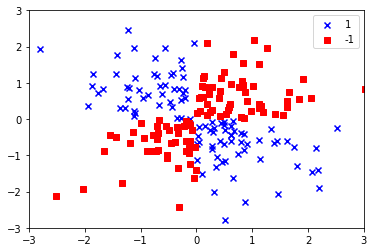

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 
np.random.seed(1)
X_xor = np.random.randn(200, 2) # Generate 200 by 2 (column 0 and column 1) arrays with mean zero and variance 1
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0) # apply Xor to True, True or False, False = True else False
y_xor = np.where(y_xor, 1, -1) # If y_xor == true then y_xor =1 else -1

plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1],c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.show()

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl,
                    edgecolor='black')
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],c='', edgecolor='black', alpha=1.0,linewidth=1, marker='o',
                    s=100, label='test set')

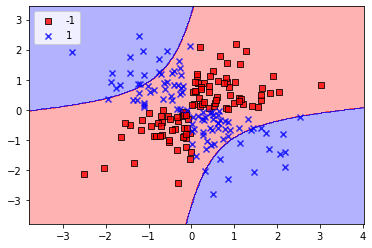

In [7]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#from mlxtend.plotting import plot_decision_regions

svm = SVC(kernel='poly', random_state=1, degree=2,  C=.001)
#svm = SVC(kernel='poly', random_state=1, degree=1)
# higher C less regularization (more complex). Very high C --- perfect training set in exchange for overfitting
# coef0 higher value you are prioritizing the higher degree

svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

Find here the possible basis functions, for the linearSVC previously discussed simply set kernel = linear, the default for SVC is 'rbf' or radial basis function. Other options are: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, see here https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

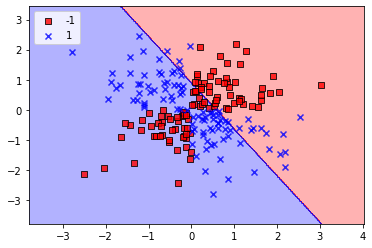

In [8]:
svm = SVC(kernel= 'linear', random_state=1, C =1)
#svm = SVC(kernel='poly', random_state=1, degree=1)
# higher C less regularization (more complex). Very high C --- perfect training set in exchange for overfitting
# coef0 higher value you are prioritizing the higher degree

svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

## Breakout Rooms: 7 minutes discuss with learning teams

One of the most widely used kernels is the Radial Basis Function (RBF) kernel or simply called the Gaussian kernel:

\begin{equation}
\kappa(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})=\exp(\frac{-||\mathbf{x}^{(i)}-\mathbf{x}^{(j)}||^2}{2\sigma^2})
\end{equation}


This is often simplified to:

\begin{equation}
\kappa(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})=\exp(-\gamma ||\mathbf{x}^{(i)}-\mathbf{x}^{(j)}||^2)
\end{equation}

Here, $\gamma=\frac{1}{2\sigma^2}$ is a free parameter that is to be optimized. The $\gamma$ parameter can be understood as a **cut-off** parameter for the Gaussian sphere. If we increase the value for $\gamma$ , we increase the influence or reach of the training samples which leads to a tighter and bumpier decision boundary (more complex, less regularized) and hence prune to overfitting. For very small $\gamma$ we approximate averaging and hence a linear SVM kernel.

Roughly speaking, the term kernel can be interpreted as a similarity function between a pair of samples. The minus sign inverts the distance measure into a similarity score, and, due to the exponential term, the resulting similarity score will fall into a range between 1 (for exactly similar samples) and 0 (for very dissimilar
samples).

Now that we defined the big picture behind the kernel trick, let us see if we can train a kernel SVM that is able to draw a nonlinear decision boundary that separates the XOR data well. Here, we simply use the SVC class from scikit-learn that we imported earlier and replace the *kernel='linear'* parameter with *kernel='rbf'*. 


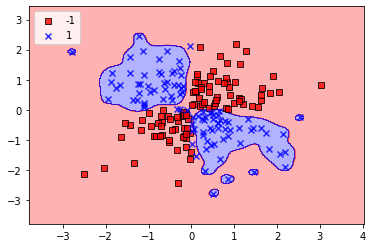

In [9]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

svm = SVC(kernel='rbf', random_state=1, gamma=10, C=.001)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

## Breakout Rooms: 7 minutes to discuss with your learning teams

As we can see in the resulting plot, the kernel SVM separates the XOR data relatively
well:

## Example 2.  Iris flower data set

To get a better intuition for $\gamma$, let us apply an RBF kernel SVM to
the Iris flower dataset:

In [10]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


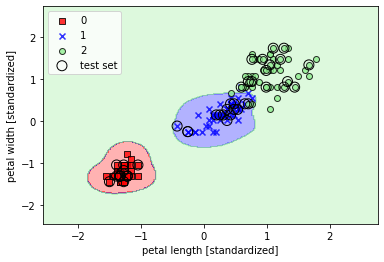

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  2, 48]])

In [11]:
svm = SVC(kernel='rbf', random_state=10, gamma=10, C=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix
y_combined_predict=svm.predict(X_combined_std)
confusion_matrix(y_combined,y_combined_predict )

Since we chose a relatively small value for $gamma$ (=0.02) , the resulting decision boundary of the
RBF kernel SVM model will be relatively soft, as shown in the above figure.  Now, let us increase the value of $gamma$(=1) and observe the effect on the decision boundary.

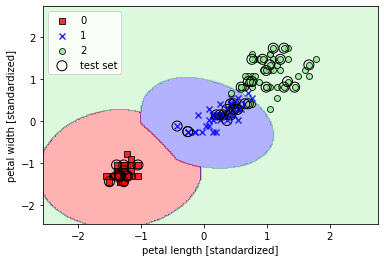

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  3, 47]])

In [12]:
svm = SVC(kernel='rbf', random_state=10, gamma=1, C=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix
y_combined_predict=svm.predict(X_combined_std)
confusion_matrix(y_combined,y_combined_predict )

In the resulting plot, we can now see that the decision boundary around the classes 0
and 1 is much tighter using a relatively large value of $\gamma$. Although the model fits the training dataset very well, such a classifier will likely have a high generalization error on unseen data. This illustrates that the $\gamma$ parameter also plays an important role in controlling overfitting.

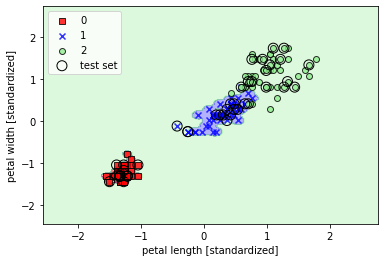

array([[48,  0,  2],
       [ 0, 45,  5],
       [ 0,  0, 50]])

In [13]:
svm = SVC(kernel='rbf', random_state=10, gamma=200, C=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix
y_combined_predict=svm.predict(X_combined_std)
confusion_matrix(y_combined,y_combined_predict )

Of course, as discussed above another kernel choice is the "n-degree'' polynomial fit, for the case of degree=1, you reduced yourself to the case of linear SVM. Play around with the examples below using the IRIS and XOR data.

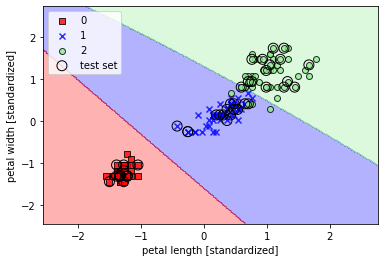

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  6, 44]])

In [14]:
svm = SVC(kernel='poly', degree=2.5, coef0=1, C=.1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

from sklearn.metrics import confusion_matrix
y_combined_predict=svm.predict(X_combined_std)
confusion_matrix(y_combined,y_combined_predict )

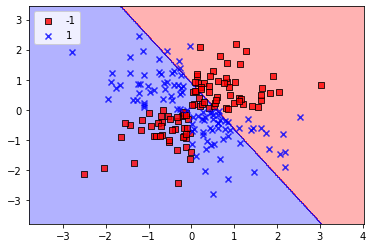

In [15]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

svm = SVC(kernel='poly', random_state=1, degree=1, coef0=1, C=1, gamma='auto')
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

### Key Take aways

1. Linear Support vector machine can be be easily *kernelized* to solve nonlinear classification problems.

2. The parameter C serves a similar purpose as before, higher C lower regularization (higher chance of overfitting) and lower C higher regularization (more prone to underfitting).

3. Default is the radial basis function that becomes closer to linear SVM when the gamma parameter is lowered.